In [51]:
import numpy as np

def read_xyz(filename):
    """
    Reads the XYZ file and returns a list of geometries.
    Each geometry is a list of atom names and coordinates (x, y, z).
    """
    geometries = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        # Try to read the number of atoms; skip non-integer lines
        try:
            num_atoms = int(lines[i].strip())
        except ValueError:
            # Skip this line if it's not an integer (invalid header or metadata)
            i += 1
            continue
        
        # Read the comment line or skip it
        comment = lines[i+1].strip()
        
        geometry = []
        # Start reading the atom coordinates
        for j in range(1, num_atoms):  # Start from the second atom (skip the first)
            atom_data = lines[i+2+j].split()
            atom = atom_data[0]
            coords = list(map(float, atom_data[1:4]))
            geometry.append((atom, coords))
        
        geometries.append(geometry)
        i += num_atoms + 2  # Move to the next geometry block

    return geometries

def write_xyz(filename, geometries):
    """
    Writes the list of geometries to an XYZ file.
    Each geometry is a list of atom names and coordinates (x, y, z).
    """
    with open(filename, 'w') as f:
        for geometry in geometries:
            f.write(f"{len(geometry)}\n")
            f.write("Generated geometry step with added geometric mean coordinate(s)\n")
            for atom, coords in geometry:
                f.write(f"{atom} {coords[0]:.6f} {coords[1]:.6f} {coords[2]:.6f}\n")

def geometric_mean(coords):
    """
    Calculates the geometric mean of a list of coordinates.
    Input should be a list of [x, y, z] coordinates.
    Handles negative and zero values by taking the absolute value.
    """
    coords = np.array(coords)
    
    # Take the absolute value to avoid issues with negative or zero values
    coords = np.abs(coords)
    
    # Return the geometric mean
    return np.exp(np.mean(np.log(coords), axis=0))


def add_geometric_means_to_geometries(geometries, guest_indices_list):
    """
    Adds up to three geometric means (one for each set of guest indices) to each geometry.
    The new atoms will be labeled 'GM1', 'GM2', and 'GM3'.
    """
    updated_geometries = []
    
    for geometry in geometries:
        for idx, guest_indices in enumerate(guest_indices_list):
            # Extract coordinates of the atoms corresponding to guest indices
            selected_coords = [geometry[i][1] for i in guest_indices]
            
            # Calculate the geometric mean of the selected coordinates
            gm_coords = geometric_mean(selected_coords)
            
            # Append the geometric mean as a new atom labeled 'GM1', 'GM2', etc.
            geometry.append((f'GM{idx+1}', gm_coords))
        
        updated_geometries.append(geometry)
    
    return updated_geometries

def process_xyz(input_filename, output_filename, guest_indices_list):
    # Step 1: Read the geometries from the input XYZ file
    geometries = read_xyz(input_filename)
    
    # Step 2: Add the geometric means for each set of guest indices to each geometry
    updated_geometries = add_geometric_means_to_geometries(geometries, guest_indices_list)
    
    # Step 3: Write the updated geometries to the output XYZ file
    write_xyz(output_filename, updated_geometries)

# Example usage
input_filename = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/graphite-md-02.xyz'
output_filename = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/graphite-md-altered.xyz'

# Example: up to three sets of guest atom indices
guest_indices_list = [
    [1451, 1452, 1453, 1454, 1448, 1449],  # First geometric mean
    [1441, 1442, 1443, 1444, 1445, 1446],  # Second geometric mean (optional)
   # [6, 7, 8]   # Third geometric mean (optional)
]

process_xyz(input_filename, output_filename, guest_indices_list)


<ipython-input-51-8d0358a03bf3>:62: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.mean(np.log(coords), axis=0))


In [52]:
import os
import pandas as pd

# Directory containing the .xyz files to analyze 
directory = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/'

# Save lattice parameters in separate dataframe
latticefilename = 'graphite-md-altered.xyz'
lattice = pd.read_csv(os.path.join(directory, latticefilename), delimiter='\s+', header=None, skiprows=range(2, 12500), nrows=1)

numAtoms = lattice[0][0] - 1

#guest_indices = [1474, 1470, 1449, 1444, 1445, 1469, 1448, 1463, 1458, 1459, 1442, 1443, 1457, 1462, 1472, 1473, 1471, 1456] # Which atoms to track
guest_indices = [numAtoms+1, numAtoms+2]
dfs = []

# Loop through xyz files, create dataframes from them, clean them up, add indices and add them to the list of dataframes
for i, filename in enumerate(sorted(os.listdir(directory))):
    if filename.endswith('.xyz') and filename.startswith('graphite-md-02'): #change prefix
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delimiter='\s+', header=None, skiprows=1)
        df['run'] = filename
        # drop all rows that are NaN
        df = df[~df.iloc[:, 1].isna()]
        # drop all rows that are an X element
        df = df[df[0] != 'X']
        # reset the Index of the dataframe
        df.reset_index(drop=True, inplace=True)
        # add cleanedIndex to each row representing its index in the simulation, going from 1 to numAtoms then start at 1 again
        df['cleanedIndex'] = (df.index) % (numAtoms) + 1
        #drop the entire row if the cleanedIndex is not in the guest_indices list
        df = df[df['cleanedIndex'].isin(guest_indices)]
        # append to the list of dataframes
        dfs.append(df)
        
# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)


In [53]:
lattice_x = lattice[1][0]
lattice_y = lattice[2][0]

# Save second and third column of dataframe
x_values = df.iloc[:, 1]
y_values = df.iloc[:, 2]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Adjust x-axis range and center it at zero
plt.hist2d(x_values, y_values, bins=500, cmap='binary', range=[[-lattice_x/2, lattice_x/2], [-lattice_y/2, lattice_y/2]])
plt.colorbar()
plt.xlabel('X Lattice Parameter (Angstrom)')
plt.ylabel('Y Lattice Parameter (Angstrom)')
plt.title('Substrate Movement Heatmap')

plt.gca().set_aspect('equal')  # Set aspect ratio to 'equal'+
plt.savefig("/home/sal/Desktop/Heatmap_aq.png", dpi = 300)

plt.show()



KeyError: 1

0         3.5234
1         3.3594
2         3.3757
3         3.5262
4         3.2878
           ...  
224995    3.3610
224996    3.0269
224997    3.0040
224998    2.9928
224999    3.3627
Name: 3, Length: 225000, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '/home/mfi/Desktop/mfi/images/Histogram2Guest.png'

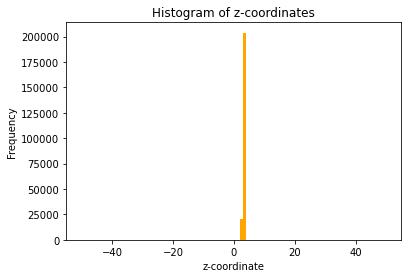

In [27]:
z_lattice = lattice[3][0]
z_values = df.iloc[:, 3]
print(z_values)

#Plot a histogram of the z values
plt.hist(z_values, bins=100, color='orange' ,range=[-z_lattice/2, z_lattice/2])
plt.xlabel('z-coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of z-coordinates')
plt.savefig("/home/mfi/Desktop/mfi/images/Histogram2Guest.png")

plt.show()



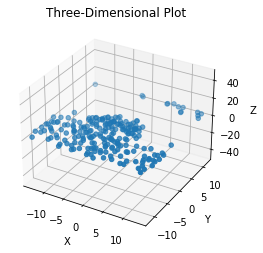

In [29]:
# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot every thousandth step
ax.scatter(x_values[::1000], y_values[::1000], z_values[::1000])

# Set ranges to lattice values
ax.set_xlim(-lattice_x/2, lattice_x/2)
ax.set_ylim(-lattice_y/2, lattice_y/2)
ax.set_zlim(-z_lattice/2, z_lattice/2)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Three-Dimensional Plot')

# Show the plot
plt.show()